In [1]:
#checking mean and similarity on 50 random models (mlp)

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

# Import the MNIST model from models.py
from models import MNISTNet

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to initialize a model with a given seed
def init_model(seed):
    torch.manual_seed(seed)
    return MNISTNet().to(device)

# Function to calculate gradient similarity between two models
def calculate_gradient_similarity(model1, model2):
    # Create dummy data
    dummy_input = torch.randn(100, 3, 28, 28).to(device)
    dummy_target = torch.randint(0, 10, (100,)).to(device)
    
    criterion = nn.CrossEntropyLoss(reduction='none')
    
    # Calculate gradients
    grad1 = get_gradients_simple(dummy_input, dummy_target, model1, criterion)
    grad2 = get_gradients_simple(dummy_input, dummy_target, model2, criterion)
    
    # Calculate similarity
    similarity = np.dot(grad1, grad2) / (np.linalg.norm(grad1) * np.linalg.norm(grad2))
    
    return similarity

def get_gradients_simple(X, y, model, criterion):
    model.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y).mean()  # Use mean reduction
    loss.backward()
    
    grad_list = []
    for name, p in model.named_parameters():
        if p.grad is not None:
            grad_list.append(p.grad.detach().cpu().numpy().flatten())
    
    return np.concatenate(grad_list)

# Run the experiment
n_pairs = 50
similarities = []

for i in range(n_pairs):
    model1 = init_model(seed=i)
    model2 = init_model(seed=i+n_pairs)
    
    similarity = calculate_gradient_similarity(model1, model2)
    similarities.append(similarity)

# Calculate statistics
mean_similarity = np.mean(similarities)
std_similarity = np.std(similarities)

print(f"Mean gradient similarity: {mean_similarity:.4f}")
print(f"Standard deviation of gradient similarity: {std_similarity:.4f}")

Mean gradient similarity: 0.0263
Standard deviation of gradient similarity: 0.0190


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

# Import the MNIST model from models.py
from models import MNISTNet

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to initialize a model with a given seed
def init_model(seed):
    torch.manual_seed(seed)
    return MNISTNet().to(device)

def gray_to_rgb(img):
    return img.repeat(3, 1, 1)

def load_mnist_data():
    # Define data transform for MNIST data
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Lambda(gray_to_rgb), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Generate MNIST training data
    trainset = torchvision.datasets.MNIST(
        root='./data', 
        train=True,
        download=True, 
        transform=transform,
    )
    
    trainloader = DataLoader(trainset, batch_size=100, shuffle=True)
    
    return next(iter(trainloader))

# Function to calculate gradient similarity between two models
def calculate_gradient_similarity(model1, model2, inputs, targets):
    criterion = nn.CrossEntropyLoss(reduction='none')
    
    # Calculate gradients
    grad1 = get_gradients_simple(inputs, targets, model1, criterion)
    grad2 = get_gradients_simple(inputs, targets, model2, criterion)
    
    # Calculate similarity
    similarity = np.dot(grad1, grad2) / (np.linalg.norm(grad1) * np.linalg.norm(grad2))
    
    return similarity

def get_gradients_simple(X, y, model, criterion):
    model.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y).mean()  # Use mean reduction
    loss.backward()
    
    grad_list = []
    for name, p in model.named_parameters():
        if p.grad is not None:
            grad_list.append(p.grad.detach().cpu().numpy().flatten())
    
    return np.concatenate(grad_list)

# Load MNIST data
inputs, targets = load_mnist_data()
inputs, targets = inputs.to(device), targets.to(device)

# Run the experiment
n_pairs = 50
similarities = []

for i in range(n_pairs):
    model1 = init_model(seed=i)
    model2 = init_model(seed=i+n_pairs)
    
    similarity = calculate_gradient_similarity(model1, model2, inputs, targets)
    similarities.append(similarity)

# Calculate statistics
mean_similarity = np.mean(similarities)
std_similarity = np.std(similarities)

print(f"Mean gradient similarity: {mean_similarity:.4f}")
print(f"Standard deviation of gradient similarity: {std_similarity:.4f}")

Mean gradient similarity: 0.0109
Standard deviation of gradient similarity: 0.0563


In [ ]:
# Checking grad similarity with M1 and M2. This does it the exact same way as in the original code.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

from models import MNISTNet
from train_task import make_tasks_data, get_gradients, combine_memory_sets

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def gray_to_rgb(img):
    return img.repeat(3, 1, 1)

def load_mnist_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(gray_to_rgb),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform,
    )

    return trainset

def init_model(seed):
    torch.manual_seed(seed)
    return MNISTNet().to(device)

def calculate_gradient_similarity(model_1, model_2, random_model, combined_train_x, combined_train_y, criterion):
    # Evaluate model gradients on combined training set
    model_1_full_grad = get_gradients(combined_train_x, combined_train_y, model_1, criterion)
    model_2_full_grad = get_gradients(combined_train_x, combined_train_y, model_2, criterion)
    random_model_grad = get_gradients(combined_train_x, combined_train_y, random_model, criterion)

    # Compute gradient similarity for model 1 and 2 vs random model on full training sets
    sim_1 = np.dot(model_1_full_grad, random_model_grad) / (np.linalg.norm(model_1_full_grad) * np.linalg.norm(random_model_grad))
    sim_2 = np.dot(model_2_full_grad, random_model_grad) / (np.linalg.norm(model_2_full_grad) * np.linalg.norm(random_model_grad))

    return sim_1, sim_2

# Load MNIST data
trainset = load_mnist_data()

# Create tasks data
num_tasks = 5
classes_per_task = 2
max_data_size = 6000
tasks_data, _ = make_tasks_data(trainset, trainset, num_tasks=num_tasks, max_data_size=max_data_size, classes_per_task=classes_per_task)

# Combine training data for tasks 1 through T-1 (omit the last task)
combined_train_x, combined_train_y = combine_memory_sets(tasks_data, omit_task=1)
combined_train_x, combined_train_y = combined_train_x.to(device), combined_train_y.to(device)

# Load pre-trained M1 and M2 models
model_1 = MNISTNet().to(device)
model_2 = MNISTNet().to(device)
model_1.load_state_dict(torch.load('ideal_models_M1.pth'))
model_2.load_state_dict(torch.load('ideal_models_M2.pth'))

criterion = nn.CrossEntropyLoss(reduction='none')

n_pairs = 1
similarities_1 = []
similarities_2 = []

for i in range(n_pairs):
    random_model = init_model(seed=i)
    sim_1, sim_2 = calculate_gradient_similarity(model_1, model_2, random_model, combined_train_x, combined_train_y, criterion)
    similarities_1.append(sim_1)
    similarities_2.append(sim_2)

# Calculate statistics
mean_similarity_1 = np.mean(similarities_1)
std_similarity_1 = np.std(similarities_1)
mean_similarity_2 = np.mean(similarities_2)
std_similarity_2 = np.std(similarities_2)

print(f"M1 - Mean gradient similarity: {mean_similarity_1:.4f}")
print(f"M1 - Standard deviation of gradient similarity: {std_similarity_1:.4f}")
print(f"M2 - Mean gradient similarity: {mean_similarity_2:.4f}")
print(f"M2 - Standard deviation of gradient similarity: {std_similarity_2:.4f}")

task 0, classes 0, 1


KeyboardInterrupt: 

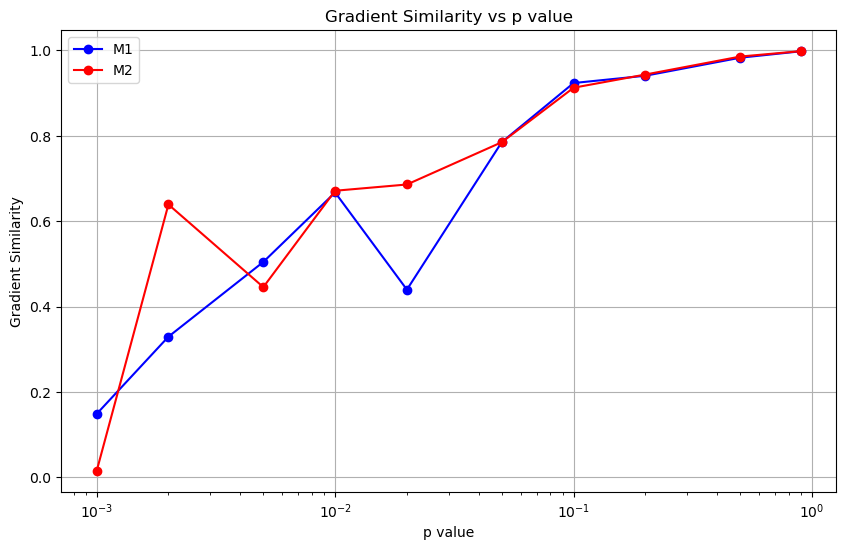

p = 0.001: M1 similarity = 0.1487, M2 similarity = 0.0148
p = 0.002: M1 similarity = 0.3297, M2 similarity = 0.6393
p = 0.005: M1 similarity = 0.5047, M2 similarity = 0.4458
p = 0.010: M1 similarity = 0.6674, M2 similarity = 0.6715
p = 0.020: M1 similarity = 0.4399, M2 similarity = 0.6861
p = 0.050: M1 similarity = 0.7854, M2 similarity = 0.7852
p = 0.100: M1 similarity = 0.9238, M2 similarity = 0.9128
p = 0.200: M1 similarity = 0.9409, M2 similarity = 0.9437
p = 0.500: M1 similarity = 0.9831, M2 similarity = 0.9858
p = 0.900: M1 similarity = 0.9982, M2 similarity = 0.9985


In [10]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from models import MNISTNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def gray_to_rgb(img):
    return img.repeat(3, 1, 1)

def load_mnist_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(gray_to_rgb),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    return trainset

def random_sample_mnist(trainset, exclude_classes):
    indices = []
    labels = []
    for i, (_, label) in enumerate(trainset):
        if label not in exclude_classes:
            indices.append(i)
            labels.append(label)
    
    sampled_data = torch.stack([trainset[i][0] for i in indices])
    sampled_labels = torch.tensor(labels)
    
    return sampled_data, sampled_labels

def get_gradients(X, y, model, criterion):
    model.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y).mean()
    loss.backward()

    grad_list = []
    for name, p in model.named_parameters():
        if p.grad is not None:
            grad_list.append(p.grad.detach().cpu().numpy().flatten())

    return np.concatenate(grad_list)

def calculate_gradient_similarity(model, memory_x, memory_y, full_x, full_y, criterion):
    memory_grad = get_gradients(memory_x, memory_y, model, criterion)
    full_grad = get_gradients(full_x, full_y, model, criterion)
    
    similarity = np.dot(memory_grad, full_grad) / (np.linalg.norm(memory_grad) * np.linalg.norm(full_grad))
    return similarity

# Load MNIST data
trainset = load_mnist_data()

# Randomly sample MNIST data, excluding classes 8 and 9
full_x, full_y = random_sample_mnist(trainset, exclude_classes=[8, 9])
full_x, full_y = full_x.to(device), full_y.to(device)

# Load pre-trained M1 and M2 models
model_1 = MNISTNet().to(device)
model_2 = MNISTNet().to(device)
model_1.load_state_dict(torch.load('ideal_models_M1.pth'))
model_2.load_state_dict(torch.load('ideal_models_M2.pth'))

criterion = nn.CrossEntropyLoss(reduction='none')

# Define p values
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.9]
# p_values = [0.001]

similarities_1 = []
similarities_2 = []

for p in p_values:
    memory_size = int(p * len(full_x))
    indices = torch.randperm(len(full_x))[:memory_size]
    memory_x = full_x[indices]
    memory_y = full_y[indices]
    
    sim_1 = calculate_gradient_similarity(model_1, memory_x, memory_y, full_x, full_y, criterion)
    sim_2 = calculate_gradient_similarity(model_2, memory_x, memory_y, full_x, full_y, criterion)
    
    similarities_1.append(sim_1)
    similarities_2.append(sim_2)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(p_values, similarities_1, 'b-o', label='M1')
plt.plot(p_values, similarities_2, 'r-o', label='M2')
plt.xscale('log')
plt.xlabel('p value')
plt.ylabel('Gradient Similarity')
plt.title('Gradient Similarity vs p value')
plt.legend()
plt.grid(True)
plt.savefig('gradient_similarity_vs_p.png')
plt.show()

# Print results
for p, sim_1, sim_2 in zip(p_values, similarities_1, similarities_2):
    print(f"p = {p:.3f}: M1 similarity = {sim_1:.4f}, M2 similarity = {sim_2:.4f}")